<a href="https://colab.research.google.com/github/reinhardbuyabo/ICS4102/blob/main/ANN_Airline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

np.random.seed(123) # to get consisten results
tf.random.set_seed(123)

In [2]:
!pip install -U scikit-learn

In [3]:
from sklearn.metrics import mean_absolute_percentage_error

In [4]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2025-09-24 20:07:56--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: ‘airline_passengers.csv’

airline_passengers. 100%[===================>]   1.99K  --.-KB/s    in 0s      

2025-09-24 20:07:56 (29.7 MB/s) - ‘airline_passengers.csv’ saved [2036/2036]



In [5]:
df = pd.read_csv("airline_passengers.csv", index_col="Month", parse_dates=True)

In [6]:
df["LogPassengers"] = np.log(df["Passengers"])

In [7]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [8]:
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [9]:
df["DiffLogPassengers"] = df["LogPassengers"].diff()

In [17]:
series = df["DiffLogPassengers"].dropna().to_numpy()

T = 10
X = []
Y = []

for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)

N = len(X)
print("X.shape", X.shape, "Y,shape", Y.shape)

X.shape (133, 10) Y,shape (133,)


In [19]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [23]:
# Basic ANN
i = Input(shape=(T,))
x = Dense(32, activation="relu")(i)
x = Dense(1)(x)

model = Model(i, x)

In [25]:
model.compile(
    loss="mse",
    optimizer="adam",
    metrics=["mae"]
)

In [26]:
r = model.fit(
    Xtrain, Ytrain,
    validation_data=(Xtest, Ytest),
    epochs=100
)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0209 - mae: 0.1275 - val_loss: 0.0147 - val_mae: 0.1100
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0190 - mae: 0.1208 - val_loss: 0.0136 - val_mae: 0.1037
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0177 - mae: 0.1154 - val_loss: 0.0129 - val_mae: 0.0988
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0166 - mae: 0.1109 - val_loss: 0.0123 - val_mae: 0.0954
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0155 - mae: 0.1070 - val_loss: 0.0117 - val_mae: 0.0924
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0145 - mae: 0.1030 - val_loss: 0.0111 - val_mae: 0.0898
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0135 - mae: 0.0992 - val_loss: 0.0105 - val_mae: 0.0875
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0126 - mae: 0.0954 - val_loss: 0.0100 - val_mae: 0.0852
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0117 - mae: 

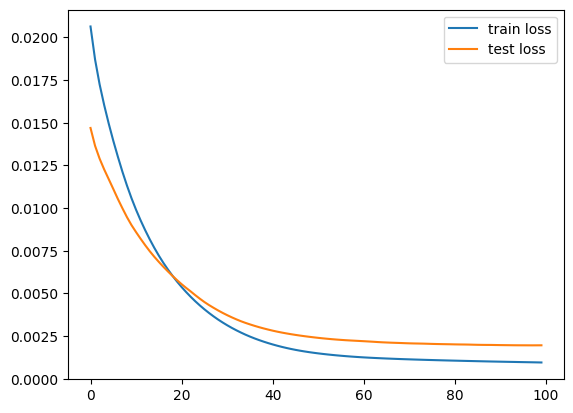

In [27]:
plt.plot(r.history["loss"], label="train loss")
plt.plot(r.history["val_loss"], label="test loss")
plt.legend()

In [28]:
train_idx[:T+1] = False # first T+1 values are not predictable

In [29]:
Ptrain = model.predict(Xtrain).flatten()
Ptest = model.predict(Xtest).flatten()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


In [30]:
# Store difference predictions
df.loc[train_idx, 'Diff ANN Train Prediction'] = Ptrain
df.loc[test_idx, 'Diff ANN Test Prediction'] = Ptest

<Axes: xlabel='Month'>

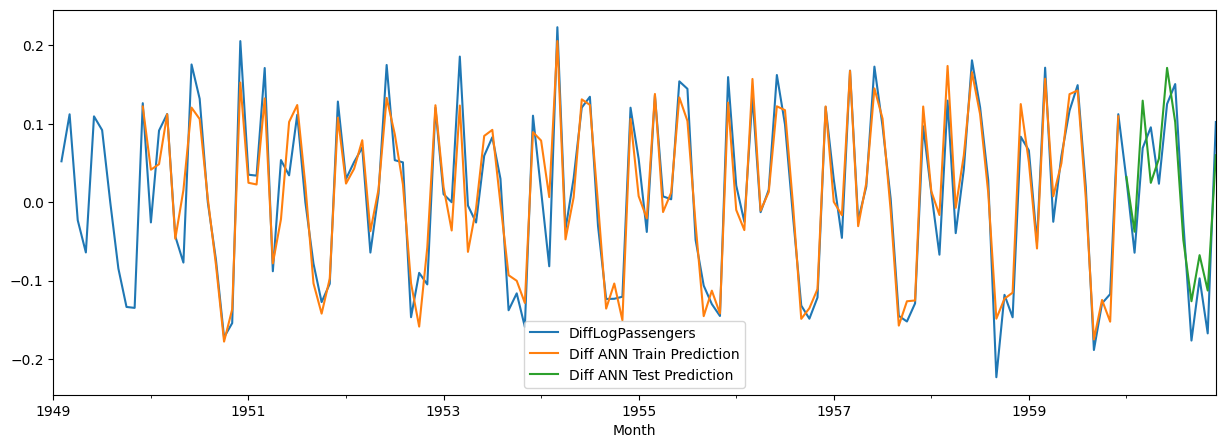

In [33]:
cols = ['DiffLogPassengers', 'Diff ANN Train Prediction', 'Diff ANN Test Prediction']
df[cols].plot(figsize=(15, 5))

In [36]:
df['ShiftLogPassgners'] = df['LogPassengers'].shift(1)
prev = df['ShiftLogPassgners']

In [38]:
last_train = train.iloc[-1]['LogPassengers']

In [39]:
# 1 step forecast
df.loc[train_idx, '1step_train'] = prev[train_idx] + Ptrain
df.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest

<Axes: xlabel='Month'>

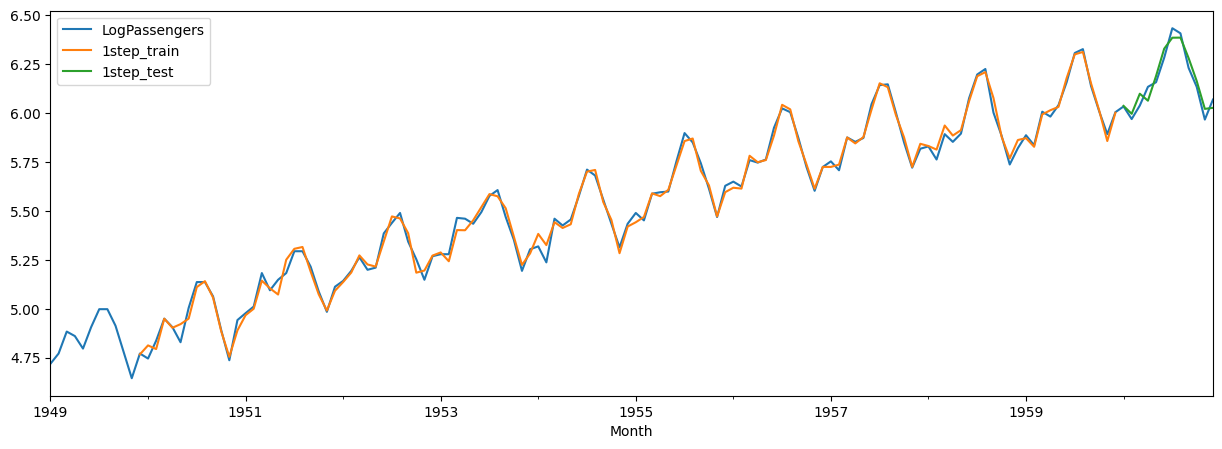

In [40]:
# plot 1-step forecast
df[['LogPassengers', '1step_train', '1step_test']].plot(figsize=(15, 5))

In [44]:
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
  p = model.predict(last_x.reshape(1, -1))[0]

  # update the predictions list
  multistep_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/tmp/ipython-input-1355337906.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_x[-1] = p
/tmp/ipython-input-1355337906.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_x[-1] = p


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [45]:
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

<Axes: xlabel='Month'>

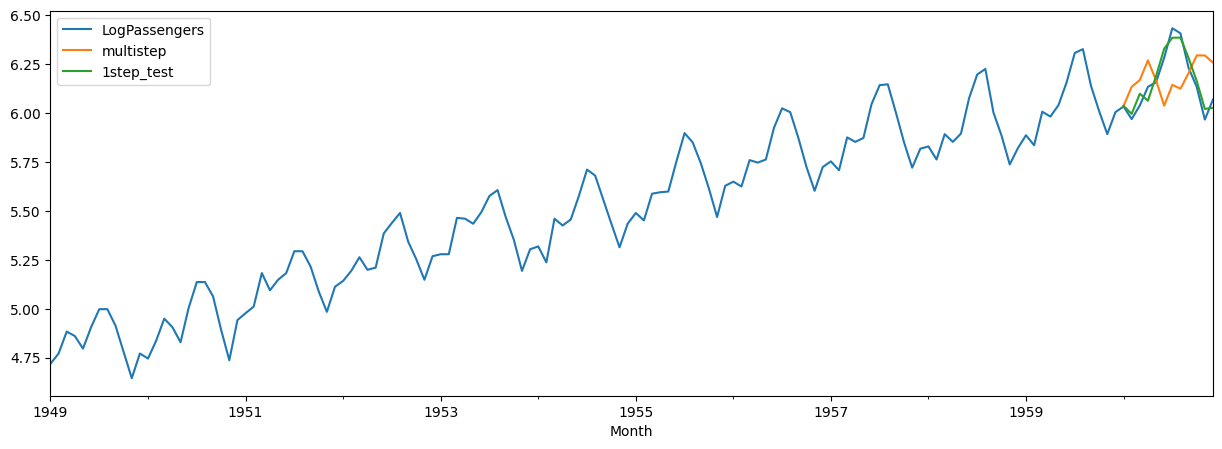

In [47]:
df[['LogPassengers', 'multistep', '1step_test']].plot(figsize=(15,5))

In [49]:
# make multi-output supervised dataset
Tx = T
Ty = Ntest
X = []
y = []
for t in range(len(series) - Tx - Ty):
  x = series[t:t+Tx]
  X.append(x)
  yy = series[t+Tx:t+Tx+Ty]
  y.append(yy)